# Importing Libraries

In [1]:
import copy
import numpy as np
from utils import *

from copy import deepcopy
from pylops.utils import *
from numpy.linalg import norm
import matplotlib.pyplot as plt
from devito import configuration
from scipy.ndimage import gaussian_filter
from pylops.waveeqprocessing.twoway import  AcousticWave2D

configuration['log-level'] = 'ERROR'

## Initializing Model Parameters

The foundation of **Pylops** functionality lies in the use of operators, in this case, the 2D acoustic operator (**AcousticWave2D**). This operator wraps **DEVITO** objects, such as SeismicModel, which includes the velocity model, time step (dt), and other details and Geometry, which contains all the necessary geometry information, such as receiver and source coordinates.

By encapsulating these objects, users only need to focus on the parameters to be applied, rather than on how the underlying objects are built.

Below are the parameters required for creating the **AcousticWave2D** operator.

In [2]:
# Modelling parameters (in meters, seconds and Hz)
par = {
    'nx': 369,   'dx': 25.,    'ox': 2,
    'nz': 375,   'dz': 8.,     'oz': 0,
    'ns': 50,    'ds': 175,    'sz': 1,
    'nr': 369,   'dr': 25,     'rz': 1,
    'nt': 5000,  'dt': 0.0008, 't0': 0.,
    'nw': 30,    'freq': 17
}

shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
src_type = 'Ricker'
dtype = np.float32
space_order = 32
nbl = 40

In [3]:
# Setting model velocity path
path_true_model="data/model-t.bin"
path_initial_model='data/model-inicial.bin'

# Loading model velocity
vp = (np.fromfile(path_true_model, np.float32)/1000).reshape(par['nx'], par['nz'])

# Applying water layer
msk = create_mask_value(vp, 1.52)
vp_min = np.min(vp)
vp_max = np.max(vp)

# Generating initial model
# sigma = [15,10] 
# vp0 = gaussian_filter(vp,sigma=sigma)
vp0 = (np.fromfile(path_initial_model, np.float32)/1000).reshape(par['nx'], par['nz'])

vp0[:, 0:par['nw']] = 1.52
vp[:, 0:par['nw']] = 1.52

domain_x = (shape[0]-1) * spacing[0]

# Setting receivers positions
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] # receivers positions
x_r[:, 1] = par['rz']

# Setting source positions
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] # source positions
x_s[:, 1] = par['sz']

# Setting propagation time
tn = (np.arange(par['nt'])*par['dt'])[-1]

# Creating modelling operator
Dop = AcousticWave2D(shape=shape, origin=origin, spacing=spacing, vp=vp*1e3, nbl=nbl, 
                     space_order=space_order,
                    src_x=x_s[:,0], src_z=x_s[:,1], rec_x=x_r[:,0], rec_z=x_r[:,1], t0=par['t0'], tn=tn*1e3,
                     src_type=src_type, f0=par['freq'], dtype=dtype,op_name="fwd", dt=par['dt']*1e3)

vp_true = deepcopy(vp)
vp_init = deepcopy(vp0) 

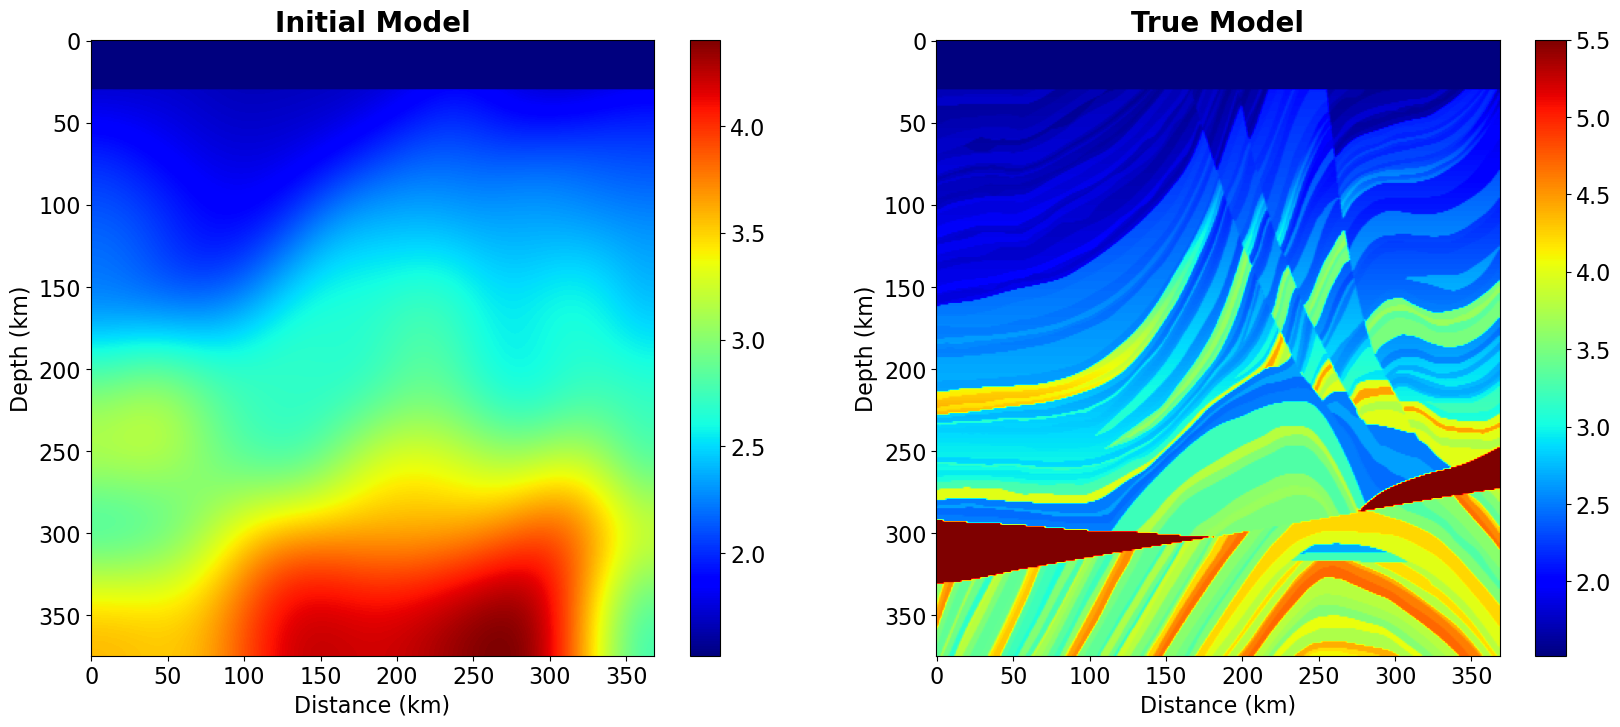

In [4]:
# Plotting velocity models
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(vp_init.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('Initial Model', fontsize=20, fontweight='bold')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(vp_true.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('True Model', fontsize=20, fontweight='bold')
plt.colorbar()

##  Generating Observed Data (Dobs)

Pylops performs forward propagation as follows:

$dobs = Dop * vptrue$, 

where $m$ represents the velocity value $vp$ em m/s.

In [5]:
dobs = Dop * vp_true

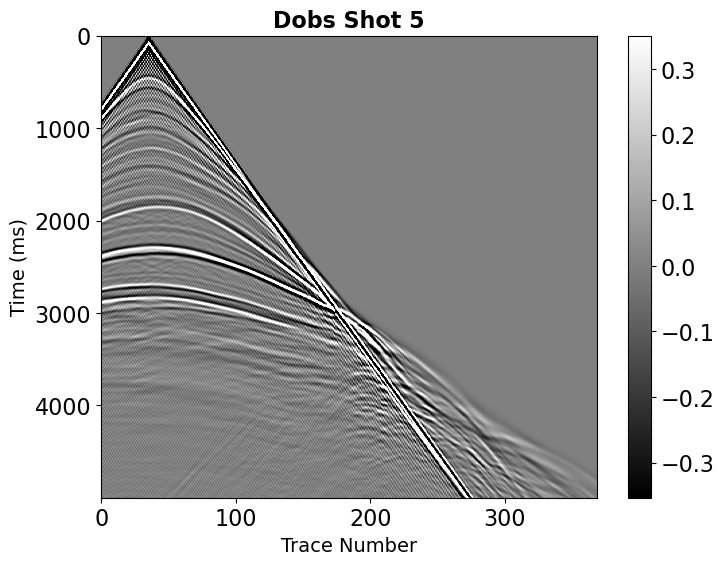

In [6]:
# Plotting Observed Data
shot_dobs = int(par['ns']/2)
plot_data(dobs,shot=shot_dobs, title=f'Dobs Shot {shot_dobs}')

# Spectrum Original Wavelet

Peak Frequency: 17 Hz | Max Frequency: 51 Hz


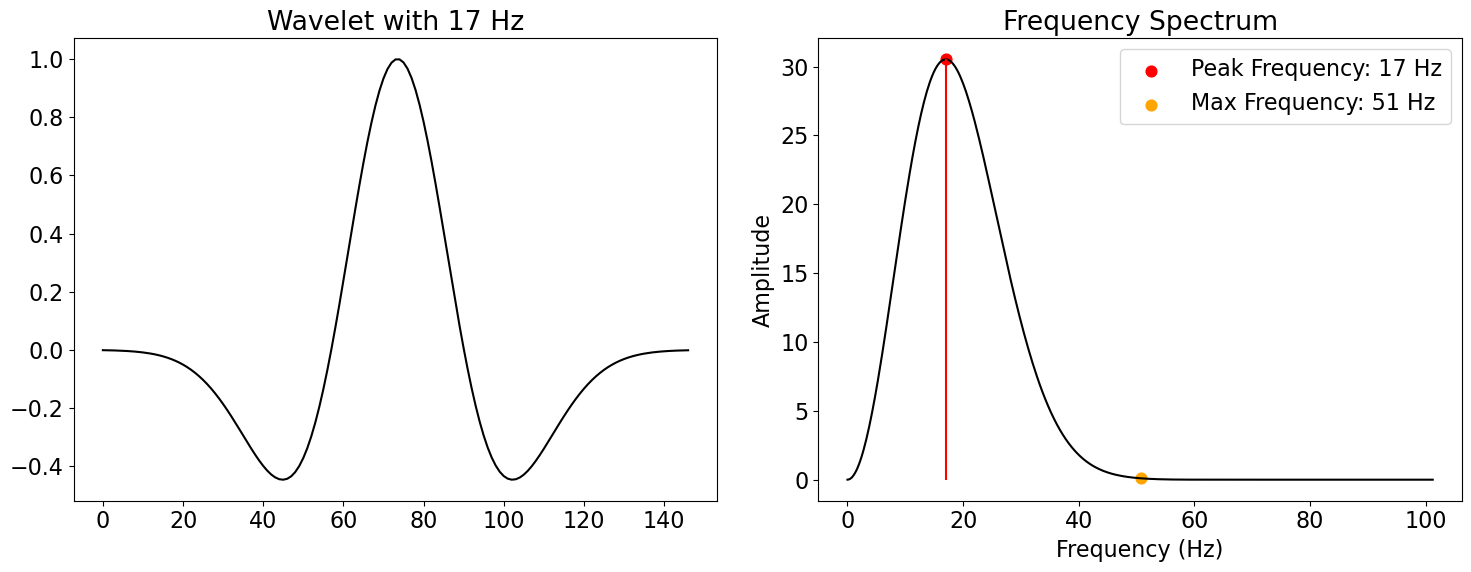

In [7]:
#plotting frequency spectrum for original wavelet
f, amp, f_peak, f_max = Frequency_spectrum(wavelet=Dop.geometry.src.wavelet, dt=par['dt'])

# Multiscale FWI

In [8]:
iterations, step, f_targ = 30, 3, 2 #20,5
freqs = np.arange(f_targ, par['freq']+step,step) #np.arange(5, 30,5) 
orig_wav = Dop.geometry.src.wavelet

fo_dict = {}
history = np.zeros((iterations, 1)) # objective function

for ifreq, freq in enumerate(freqs):
    
    print(f'Working with frequency: {freq} Hz -> {ifreq + 1}/{len(freqs)}')
    history = np.zeros(iterations)

    for iter in range(iterations):
        print("Iteration ", iter + 1)

        # generating wavelet target
        target_wav = Ricker(shape=shape, spacing=spacing, origin=origin, 
                            dt=par['dt'], nt=par['nt'], fpeak=freq, t0=par['t0'])

        # applying wiener filt
        dobsfilt = Wiener_Filt(wav_orig=orig_wav, 
                               wav_targ=target_wav, orig_data=dobs)

        # updating wavelet
        Dop.updatesrc(target_wav)

        # generating calculated data
        dcalc = Dop * vp_init

        # calculating adjoint source
        res = dobsfilt - dcalc

        # calculating objective function
        FO = .5*norm(res)**2
        print("FO: ", FO)
        print('')

        # calculating gradient
        grads = Dop.H*res

        # objective function storage
        history[iter] = FO
        fo_dict[freq] = history.tolist()
        
        grads[:,0:par['nw']] = 0.
        if iter == 0:
            alfa = .05 / np.max(grads)
        else:
            yk = grads - gradp
            sk = vp_init - vpp

            alfa = get_alfa_g(yk, sk)

        gradp = deepcopy(grads)
        vpp = deepcopy(vp_init)
       
        # update model
        dm = deepcopy(vp_init)
        vp_init = vp_init - alfa * grads
        vp_init[: ,0:par['nw']] = vp[:,0:par['nw']]
    
        np.putmask(vp_init, vp_init>vp_max, vp_max)
        np.putmask(vp_init, vp_init<vp_min, vp_min)

print('Done!')

Working with frequency: 2 Hz -> 1/6
Iteration  1
FO:  7649102.030035971

Iteration  2
FO:  5391426.554539586

Iteration  3
FO:  3843964.913862145

Iteration  4
FO:  3225094.680251749

Iteration  5
FO:  2310211.245804502

Iteration  6
FO:  1708808.8995021116

Iteration  7
FO:  1937414.994971375

Iteration  8
FO:  1322144.3370847027

Iteration  9
FO:  1268233.4159253223

Iteration  10
FO:  1179053.9403089494

Iteration  11
FO:  779915.169965179

Iteration  12
FO:  664073.7404671265

Iteration  13
FO:  1320129.3576314638

Iteration  14
FO:  517366.0809424179

Iteration  15
FO:  504236.8345637241

Iteration  16
FO:  480738.3729311974

Iteration  17
FO:  449513.88207635045

Iteration  18
FO:  393163.78237512585

Iteration  19
FO:  470894.0551861552

Iteration  20
FO:  364981.32773968996

Iteration  21
FO:  347155.653899523

Iteration  22
FO:  343073.96180461417

Iteration  23
FO:  335965.5025290565

Iteration  24
FO:  325852.1113558685

Iteration  25
FO:  318583.27506785915

Iteration  26
F

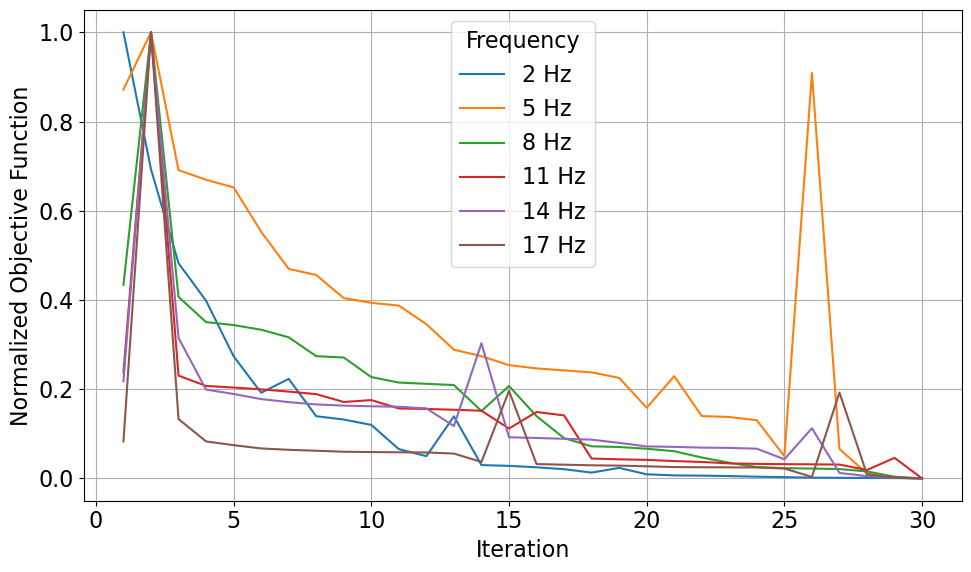

In [9]:
# from matplotlib.ticker import MultipleLocator
fo_dict_norm = {}

for freq, fo_values in fo_dict.items():
    fo_array = np.array(fo_values)
    fo_min = np.min(fo_array)
    fo_max = np.max(fo_array)
    
    # Evita divisão por zero
    if fo_max - fo_min != 0:
        fo_norm = (fo_array - fo_min) / (fo_max - fo_min)
    else:
        fo_norm = np.zeros_like(fo_array)
    
    fo_dict_norm[freq] = fo_norm


plt.figure(figsize=(10, 6))

for freq, fo_values in fo_dict_norm.items():
    plt.plot(range(1, len(fo_values) + 1), fo_values, label=f'{freq} Hz')

plt.xlabel("Iteration")
plt.ylabel("Normalized Objective Function")
plt.legend(title="Frequency")
plt.grid(True)
# plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.tight_layout()
# plt.savefig('FO_equal_fortran.png', format='png')
plt.show()

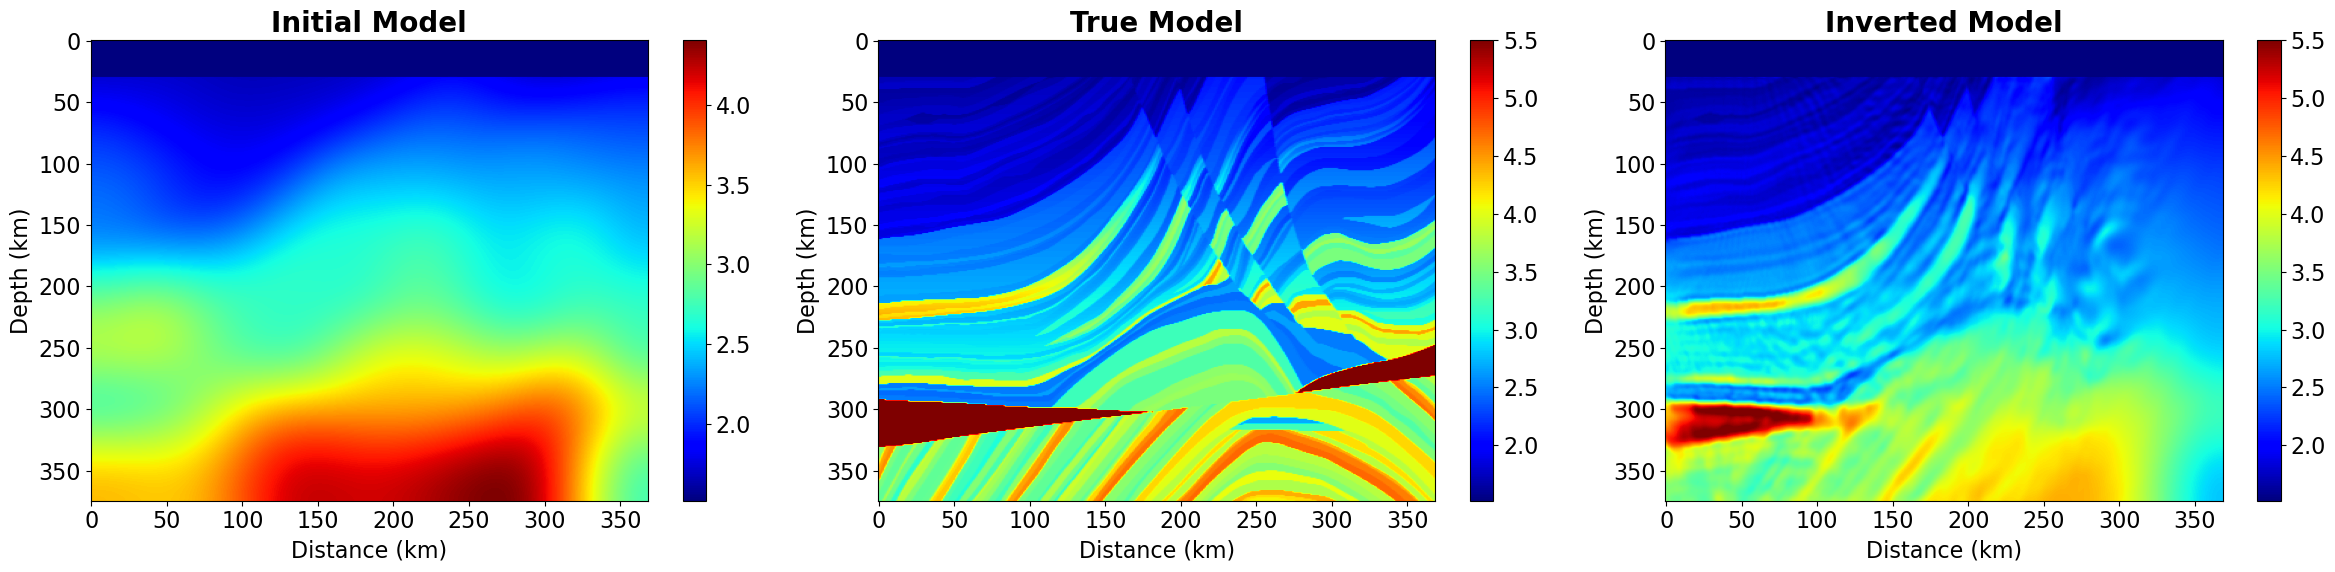

In [10]:
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.imshow(vp0.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('Initial Model', fontsize=20, fontweight='bold')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(vp.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('True Model', fontsize=20, fontweight='bold')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(vp_init.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('Inverted Model', fontsize=20, fontweight='bold')
plt.colorbar()
plt.tight_layout()
# plt.savefig('results_equal_fortran.png', format='png')

In [11]:
# np.savez_compressed('vel_final.npz', arr_0=vp_init)